Project: AI Under the Microscope 

Goal: Build a Convolutional Neural Network (CNN) to detect malaria in cell images.

The Data: We will use the NIH Malaria Dataset.
    Parasitized: Cells infected with malaria.
    Uninfected: Healthy cells.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

1. Data Collection
We will download a clean subset of the Malaria dataset provided by the TensorFlow team.

In [ ]:
print("Downloading dataset...")
dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='cell_images.zip',extract=True)# to fetch data
# ROBUST PATH FINDING
# The zip might extract to 'cell_images' or just dump the folders.
# We look for the folder containing the 'Parasitized' class.
parent_dir = os.path.dirname(data_dir)
base_dir = os.path.join(os.path.dirname(data_dir), 'cell_images')

if not os.path.exists(base_dir):
    print(f"Standard path {base_dir} not found. Searching for dataset...")
    for root, dirs, files in os.walk(parent_dir):
        if 'Parasitized' in dirs:
            base_dir = root
            break

print(f"Dataset located at: {base_dir}")

# Verify contents
print(f"Contents: {os.listdir(base_dir)}")

353452851/353452851 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step
Standard path C:\Users\tanwa\.keras\datasets\cell_images not found. Searching for dataset...
Dataset located at: C:\Users\tanwa\.keras\datasets\cell_images_extracted\cell_images
Contents: ['Parasitized', 'Uninfected']


2. Data Loading & Preprocessing
We use `image_dataset_from_directory` to load images from folders efficiently.
Batch Size: 32 images at a time.
Image Size: We resize all images to 128x128 pixels.

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

print("\nLoading Training Data...")
# 80% for Training
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print("\nLoading Validation Data...")
# 20% for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Get class names (should be 'Parasitized' and 'Uninfected')
class_names = train_ds.class_names
print(f"\nClass Names: {class_names}")


Loading Training Data...
Found 27558 files belonging to 2 classes.
Using 22047 files for training.

Loading Validation Data...
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.

Class Names: ['Parasitized', 'Uninfected']


3. Visualization
Let's look at what the AI sees.

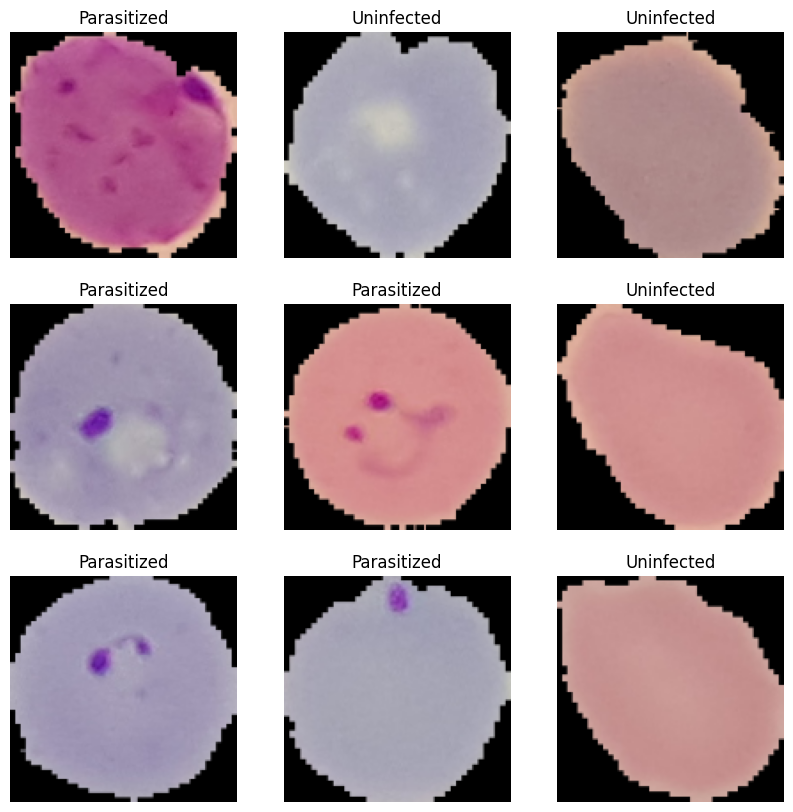

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

4. Performance Tuning
These lines optimize loading speed so the model doesn't wait for data.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

5. Building the CNN
This is the "Brain".
    1.  Rescaling: Convert pixel values from 0-255 to 0-1.
    2.  Conv2D: The filters that scan for features (edges, spots).
    3.  MaxPooling2D: Reduces the size (focuses on important parts).
    4.  Flatten: Converts the 2D grid into a 1D list.
    5.  Dense: Standard neural layers for decision making.

In [10]:
num_classes = len(class_names)

model = Sequential([
  # Preprocessing Layer
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  
  # Convolutional Block 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Convolutional Block 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Convolutional Block 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Classification Head
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # Output layer (No softmax here, we use from_logits=True later)
])

model.summary()

c:\Users\tanwa\Workshop\AIML_BioTech\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,122 (8.09 MB)

 Trainable params: 2,121,122 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

6. Compiling
We choose our Optimizer (Adam) and Loss Function (Cross Entropy). 

These are few of the variants of a lot of functions and methods we use in while running models.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

7. Training
We train for 10 epochs. Watch the accuracy go up!

In [12]:
epochs = 10
print(f"Starting training for {epochs} epochs...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Starting training for 10 epochs...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 91s 92ms/step - accuracy: 0.8261 - loss: 0.3637 - val_accuracy: 0.9445 - val_loss: 0.1610
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.9513 - loss: 0.1497 - val_accuracy: 0.9434 - val_loss: 0.1705
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9562 - loss: 0.1281 - val_accuracy: 0.9548 - val_loss: 0.1405
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9627 - loss: 0.1057 - val_accuracy: 0.9546 - val_loss: 0.1413
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9715 - loss: 0.0845 - val_accuracy: 0.9541 - val_loss: 0.1457
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9770 - loss: 0.0627 - val_accuracy: 0.9476 - val_loss: 0.1609
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.9838 - loss: 0.0460 - val_accuracy: 0.9510 - val_loss: 0.2073
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step -

8. Evaluation Results
Let's plot the learning curve.

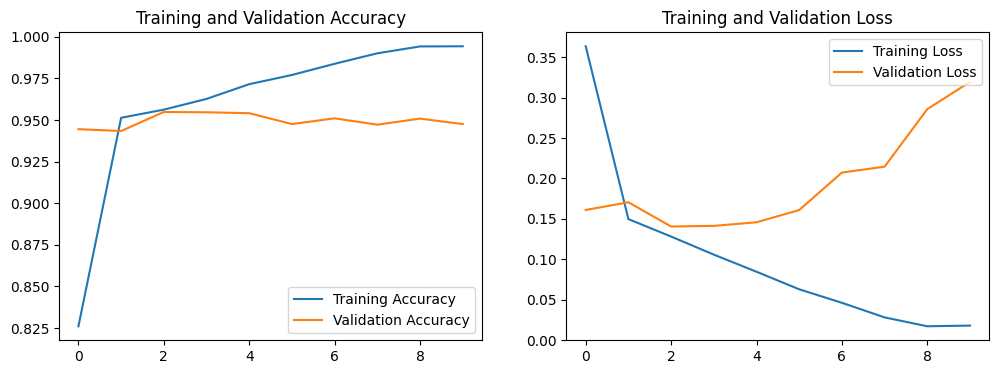

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

9. Live Prediction
Let's grab a new image and ask the model to diagnose it.


--- LIVE PREDICTION ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
True Label: Uninfected
This image most likely belongs to Parasitized with a 99.96 percent confidence.


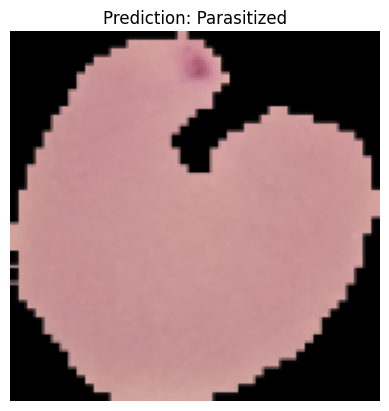

In [28]:
print("\n--- LIVE PREDICTION ---")

# Grab a random image from the validation set
img_batch, label_batch = next(iter(val_ds))
test_image = img_batch[2]
true_label = label_batch[0]

# Add batch dimension (Models expect a batch of images, not just one)
img_array = tf.expand_dims(test_image, 0) 

# Predict
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"True Label: {class_names[true_label]}")
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(test_image.numpy().astype("uint8"))
plt.title(f"Prediction: {class_names[np.argmax(score)]}")
plt.axis("off")
plt.show()